### Loading Required Libraries

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torch.optim as optim

from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.manifold import TSNE

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
BATCH_SIZE = 64         # number of data points in each batch
N_EPOCHS = 20           # times to run the model on complete data
INPUT_DIM = 28 * 28     # size of each input
HIDDEN_DIM = 256        # hidden dimension
LATENT_DIM = 10         # latent vector dimension
lr = 1e-3               # learning rate

### Loading Data

In [0]:
transforms = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.MNIST(
    './data',
    train=True,
    download=True,
    transform=transforms)

test_dataset = datasets.MNIST(
    './data',
    train=False,
    download=True,
    transform=transforms
)

train_iterator = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_iterator = DataLoader(test_dataset, batch_size=BATCH_SIZE)

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...



Done!


/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


### Batch Visualization of Given Data

In [0]:
def visualize_data(batch):
    batch = torchvision.utils.make_grid(batch)
    batch = batch.numpy()
    batch = np.transpose(batch,(1,2,0))
    plt.figure(figsize = (8,8))
    plt.imshow(batch, cmap = 'Greys_r')
    plt.show()


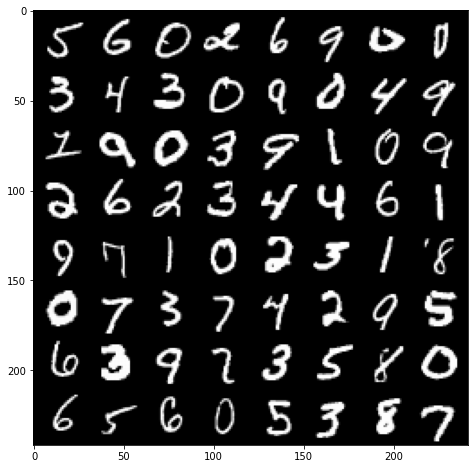

In [0]:
batch,labels = iter(train_iterator).next()
visualize_data(batch)

### Creating Model

In [0]:



class Encoder(nn.Module):
    ''' This the encoder part of VAE
    '''
    def __init__(self, hidden_dim, z_dim):
        '''
        Args:
            input_dim: A integer indicating the size of input (in case of MNIST 28 * 28).
            hidden_dim: A integer indicating the size of hidden dimension.
            z_dim: A integer indicating the latent dimension.
        '''
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels = 16, kernel_size=3)
        self.conv2 = nn.Conv2d(in_channels = 16, out_channels = 32, kernel_size = 3)

        self.linear = nn.Linear(32*24*24, 512)
        self.linear2 = nn.Linear(512, hidden_dim)

        self.mu = nn.Linear(hidden_dim, z_dim)
        self.var = nn.Linear(hidden_dim, z_dim)

    def forward(self, x):
        # x is of shape [batch_size, input_dim]
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        bs, ch, w,h = x.shape
        x = x.view(bs,ch*w*h)


        x = F.relu(self.linear(x))
        hidden = F.relu(self.linear2(x))

        # hidden is of shape [batch_size, hidden_dim]
        z_mu = self.mu(hidden)
        # z_mu is of shape [batch_size, latent_dim]
        z_var = self.var(hidden)
        # z_var is of shape [batch_size, latent_dim]

        return z_mu, z_var


In [0]:
class Decoder(nn.Module):
    ''' This the decoder part of VAE
    '''
    def __init__(self, z_dim, hidden_dim):
        
        super().__init__()

        self.linear = nn.Linear(z_dim, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, 512 )
        self.linear3 = nn.Linear(512, 18432)

        self.deconv1 = nn.ConvTranspose2d(32, 16, kernel_size=3)
        self.deconv2 = nn.ConvTranspose2d(16, 1, kernel_size = 3)

    def forward(self, x):
        # x is of shape [batch_size, latent_dim]
        x = F.relu(self.linear(x))
        x = F.relu(self.linear2(x))
        x = F.relu(self.linear3(x))
        # print(x.shape)
        x = x.view(-1, 32, 24,24)

        x = F.relu(self.deconv1(x))
        predicted = torch.sigmoid(self.deconv2(x))
        # predicted is of shape [batch_size, output_dim]
        return predicted

In [0]:
class VAE(nn.Module):
    def __init__(self, enc, dec):
        ''' This the VAE, which takes a encoder and decoder.
        '''
        super().__init__()

        self.enc = enc
        self.dec = dec

    def forward(self, x):
        # encode
        z_mu, z_var = self.enc(x)

        # sample from the distribution having latent parameters z_mu, z_var
        # reparameterize
        std = torch.exp(z_var / 2)
        eps = torch.randn_like(std)
        x_sample = eps.mul(std).add_(z_mu)

        # decode
        predicted = self.dec(x_sample)
        return predicted, z_mu, z_var


In [0]:
# encoder
encoder = Encoder( HIDDEN_DIM, LATENT_DIM)

# decoder
decoder = Decoder(LATENT_DIM, HIDDEN_DIM)

# vae
model = VAE(encoder, decoder).cuda()

# optimizer
optimizer = optim.Adam(model.parameters(), lr=lr)

# xavier weight initialization
def init_xavier(m):
    if type(m) == nn.Linear:
        nn.init.xavier_uniform(m.weight)

model.apply(init_xavier)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  from ipykernel import kernelapp as app


VAE(
  (enc): Encoder(
    (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
    (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (linear): Linear(in_features=18432, out_features=512, bias=True)
    (linear2): Linear(in_features=512, out_features=256, bias=True)
    (mu): Linear(in_features=256, out_features=10, bias=True)
    (var): Linear(in_features=256, out_features=10, bias=True)
  )
  (dec): Decoder(
    (linear): Linear(in_features=10, out_features=256, bias=True)
    (linear2): Linear(in_features=256, out_features=512, bias=True)
    (linear3): Linear(in_features=512, out_features=18432, bias=True)
    (deconv1): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(1, 1))
    (deconv2): ConvTranspose2d(16, 1, kernel_size=(3, 3), stride=(1, 1))
  )
)

In [0]:
print(model)

VAE(
  (enc): Encoder(
    (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
    (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (linear): Linear(in_features=18432, out_features=512, bias=True)
    (linear2): Linear(in_features=512, out_features=256, bias=True)
    (mu): Linear(in_features=256, out_features=10, bias=True)
    (var): Linear(in_features=256, out_features=10, bias=True)
  )
  (dec): Decoder(
    (linear): Linear(in_features=10, out_features=256, bias=True)
    (linear2): Linear(in_features=256, out_features=512, bias=True)
    (linear3): Linear(in_features=512, out_features=18432, bias=True)
    (deconv1): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(1, 1))
    (deconv2): ConvTranspose2d(16, 1, kernel_size=(3, 3), stride=(1, 1))
  )
)

### Training the Model

In [0]:
def train():
    # set the train mode
    model.train()

    # loss of the epoch
    train_loss = 0

    for i, (x, _) in enumerate(train_iterator):

        x = x.to(device)

        # update the gradients to zero
        optimizer.zero_grad()

        # forward pass
        x_sample, z_mu, z_var = model(x)

        # reconstruction loss
        recon_loss = F.binary_cross_entropy(x_sample, x, size_average=False)

        # kl divergence loss
        kl_loss = 0.5 * torch.sum(torch.exp(z_var) + z_mu**2 - 1.0 - z_var)

        # total loss
        loss = recon_loss + kl_loss

        # backward pass
        loss.backward()
        train_loss += loss.item()

        # update the weights
        optimizer.step()

    return train_loss

In [0]:
def test():
    # set the evaluation mode
    model.eval()

    # test loss for the data
    test_loss = 0

    with torch.no_grad():
        for i, (x, _) in enumerate(test_iterator):

            x = x.to(device)

            # forward pass
            x_sample, z_mu, z_var = model(x)

            # reconstruction loss
            recon_loss = F.binary_cross_entropy(x_sample, x, size_average=False)

            # kl divergence loss
            kl_loss = 0.5 * torch.sum(torch.exp(z_var) + z_mu**2 - 1.0 - z_var)

            # total loss
            loss = recon_loss + kl_loss
            test_loss += loss.item()

    return test_loss

In [0]:
def generate_data(bs=BATCH_SIZE):
    z = torch.randn(bs, LATENT_DIM).to(device)
    reconstructed_img = model.dec(z)
    img = reconstructed_img.view(-1,1,28, 28).data

    img = img.cpu()
    visualize_data(img)

In [0]:
N_EPOCHS = 20    

In [0]:
def fit():
    best_test_loss = float('inf')
    print('Before Training : ')
    generate_data()

    for e in range(N_EPOCHS):

        train_loss = train()
        test_loss = test()

        train_loss /= len(train_dataset)
        test_loss /= len(test_dataset)

        print(f'Epoch {e}, Train Loss: {train_loss:.2f}, Test Loss: {test_loss:.2f}')
        generate_data()

        if best_test_loss > test_loss:
            best_test_loss = test_loss
            patience_counter = 1
        else:
            patience_counter += 1

        if patience_counter > 3:
            break

### Saving The Weights of Best Model

In [0]:
# fit()      Training The model

# path = '/content/drive/My Drive/Colab Notebooks/deeplearning/asg3/pickle/best_vae_model_state_dict.pt'
# torch.save(model.state_dict(), path)


In [0]:
# Loading the weights of model
# model = VAE(encoder, decoder)

path = '/content/drive/My Drive/Colab Notebooks/deeplearning/asg3/pickle/best_vae_model_state_dict.pt'
model.load_state_dict(torch.load(path))


<All keys matched successfully>

### Generating grid of data Using VAE Model

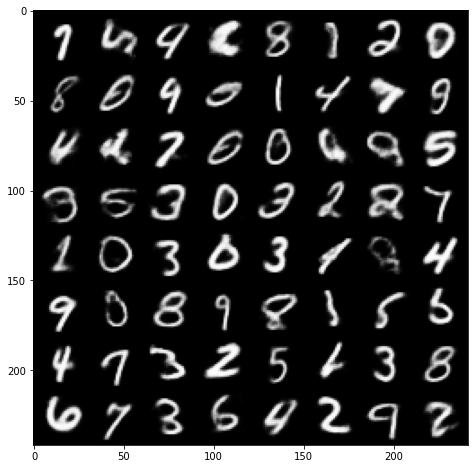

In [0]:
generate_data() # This function defined above will generate Batch Data 

### Get Latent data

In [0]:
def get_latent_data(data_iterator):

    means = np.zeros((1,10))
    vars = np.zeros((1,10))

    data_labels = []
    with torch.no_grad():
        for batch, labels in data_iterator:
            labels = list(labels.numpy())
            batch = batch.to(device)

            mean, var = model.enc(batch)

            mean = mean.to('cpu').numpy()
            var = var.to('cpu').numpy()

            means = np.vstack((means,mean))
            vars = np.vstack((vars, var))

            data_labels.extend(labels)

    means = means[1:]
    vars = vars[1:]

    return means, vars, data_labels

In [0]:
train_means, train_vars, train_labels = get_latent_data(train_iterator)

### TSNE 

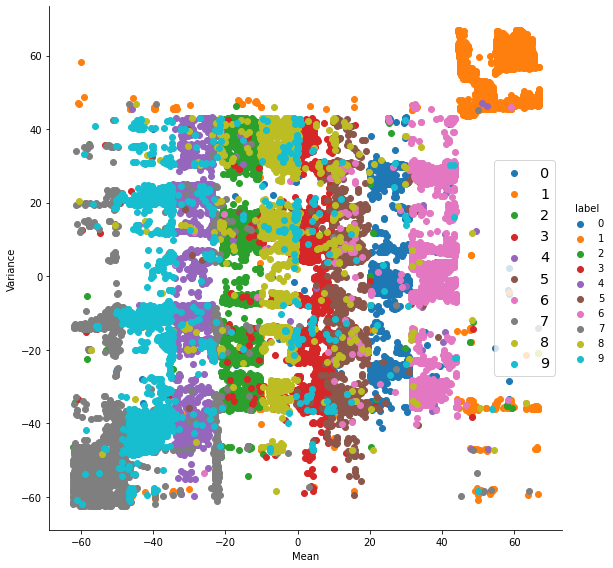

In [0]:

mean_tsne = TSNE(n_components = 1, random_state = 0)
var_tsne = TSNE(n_components = 1, random_state = 0)

tsne_mean = mean_tsne.fit_transform(train_means)
tsne_var = var_tsne.fit_transform(train_vars)


df = pd.DataFrame()
df['Mean'] = tsne_mean.squeeze(1)
df['Variance'] = tsne_var.squeeze(1)
df['label'] = train_labels

g = sns.FacetGrid(df, hue = 'label', height = 8).map(plt.scatter, 'Mean','Variance').add_legend()
plt.legend(fontsize='x-large', title_fontsize='40',loc = 'best')

plt.show()


### Getting latent data for test data

In [0]:
train_latent_data = np.column_stack((train_means, train_vars))
train_latent_df = pd.DataFrame(train_latent_data)  
train_labels = np.array(train_labels)

# test latent data 
test_means, test_vars, test_labels = get_latent_data(test_iterator)

test_latent_data = np.column_stack((test_means, test_vars))
test_latent_df = pd.DataFrame(test_latent_data)  
test_labels = np.array(test_labels)



In [0]:
print('Shape of Training data : ', train_latent_data.shape)
print('Shape of Testing Data : ', test_latent_data.shape)

Shape of Training data :  (60000, 20)
Shape of Testing Data :  (10000, 20)


### Training the SVM classifier on Latent Space

In [0]:
from sklearn.svm import LinearSVC

clf = LinearSVC(random_state=0, tol=1e-5)
clf.fit(train_latent_df, train_labels)

# prediction on test data

ypreds = clf.predict(test_latent_df)

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=0, tol=1e-05,
          verbose=0)

In [0]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score


In [0]:
def plot_confusion_matrix(cm, title, filepath):

    df_cm = pd.DataFrame(cm, index = [i for i in "0123456789"],
                      columns = [i for i in "0123456789"])

    plt.figure(figsize = (8,5))
    sns.heatmap(df_cm, annot=True, fmt='d')
    plt.title(title)
    #plt.savefig(filepath)
    plt.show()

In [0]:
test_acc = accuracy_score(ytrue, ypreds)
f_score = f1_score(ytrue, ypreds, average='macro')

prec = precision_score(ytrue, ypreds, average='macro')
recall = recall_score(ytrue, ypreds, average='macro')

cm = confusion_matrix(ytrue, ypreds)

In [0]:
print('Test Accuracy : ', test_acc)
print('Test prec : ', prec)
print('Test Recall : ', recall)
print('Test Data F - Score : ', f_score)


Test Accuracy :  0.9316
Test prec :  0.9316184285117484
Test Recall :  0.9309966925068466
Test Data F - Score :  0.9310271278772506


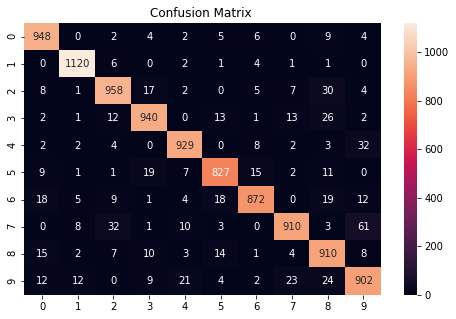

In [0]:
plot_confusion_matrix(cm, 'Confusion Matrix ','dummy')